### Example program

- From *Kernel-based Detection of Coincidentally Correct Test Cases to Improve Fault Localization Effectiveness*

```c
 e1: int Sample(int a, int b, int c) {
 e2:    int rsum, rdiv, result, rlog=0;
 e3:    result = 0;
 e4:    rdiv = 1;
 e5:    rsum = a + b;
 e6:    if ((a > 0) && (b > 0))
 e7:        rdiv = a / b;
 e8:    rmax = b;
 e9:    if (a > b)
e10:        rmax = b; // Correct: rmax = a;
e11:    if (c == 1)
e12:        result = rsum;
e13:    if (c == 2)
e14:        result = rdiv;
e15:    if (c == 3)
e16:        result = rmax;
e17:    return result;
     }
```

In [73]:
import pandas as pd

idxs = [
    "e6",
    "e7",
    "e8",
    "e9",
    "e10",
    "e11",
    "e12",
    "e13",
    "e14",
    "e15",
    "e16",
    "e17",
]

exec1_et = [0, 1, 2, 3, 4, 5, 7, 9, 10, 11]
exec2_et = [0, 2, 3, 4, 5, 7, 8, 9, 11]
exec3_et = [0, 2, 3, 5, 7, 9, 10, 11]
exec4_et = [0, 1, 2, 3, 4, 5, 6, 7, 9, 11]
exec5_et = [0, 1, 2, 3, 5, 7, 9, 10, 11]

execs = [exec1_et, exec2_et, exec3_et, exec4_et, exec5_et]

results = [1, 0, 0, 0, 0]
op2s = []
for i in range(12):
    ep, ef = 0, 0
    for exec, result in zip(execs, results):
        if i in exec:
            if result:
                ef += 1
            else:
                ep += 1
    op2 = ef - ep / (len(results) - sum(results) + 1)
    op2s.append(op2)

df = pd.DataFrame({"idx": idxs, "op2": op2s})
df["rank"] = df.op2.rank(ascending=False)
df.sort_values(by="rank", inplace=True)
df


,idx,op2,rank
1,e7,0.6,2.0
4,e10,0.6,2.0
10,e16,0.6,2.0
0,e6,0.2,7.0
2,e8,0.2,7.0
3,e9,0.2,7.0
5,e11,0.2,7.0
7,e13,0.2,7.0
9,e15,0.2,7.0
11,e17,0.2,7.0


In [74]:
import numpy as np

ALPHA = 0.99


def propagate(Is, Fe):
    return ALPHA * (1 - (1 - Is) * (1 - Fe))


def et2bayesnet(et):
    def calc_prob(prior):
        Is = 0
        for elem in et:
            Is = propagate(Is, prior[elem])
        return Is
    return calc_prob

bayesnets = [et2bayesnet(et) for et in execs]

prior = np.random.rand(12)
print("prior:", prior)
print("exec1:", bayesnets[0](prior))
print("exec2:", bayesnets[1](prior))
print("exec3:", bayesnets[2](prior))
print("exec4:", bayesnets[3](prior))
print("exec5:", bayesnets[4](prior))


prior: [0.62742529 0.37890872 0.27990035 0.14825363 0.6578819  0.19340542
 0.42108023 0.29812543 0.77628801 0.92913296 0.25927714 0.60591546]
exec1: 0.9821655765699264
exec2: 0.9854080070257131
exec3: 0.980155686328828
exec4: 0.9849536918252823
exec5: 0.9810655575509364


In [75]:
def loss(prior):
    pass_losses, fail_losses = [], []
    for result, bayesnet in zip(results, bayesnets):
        loss = np.abs(result - bayesnet(prior))
        if result:
            fail_losses.append(loss)
        else:
            pass_losses.append(loss)
    return sum(fail_losses) + sum(pass_losses) / (len(pass_losses) + 1)



print("e6", loss([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
print("e7", loss([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
print("e8", loss([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
print("e9", loss([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))
print("e10", loss([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))
print("e11", loss([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]))
print("e12", loss([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))
print("e13", loss([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
print("e14", loss([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]))
print("e15", loss([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]))
print("e16", loss([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))
print("e17", loss([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

e6 0.8264501778719969
e7 0.4537351408986714
e8 0.819179322506044
e9 0.817352851016206
e10 0.43511191035940006
e11 0.80980199002
e12 1.192119202
e13 0.809821396
e14 1.1940598
e15 0.8098606
e16 0.41194000000000003
e17 0.802


In [90]:
np.exp(-0.01  / 0.001)

4.5399929762484854e-05

In [108]:
prior_size = 12
max_iter =100000

best_estimate, best_loss = None, 100000
curr_estimate = np.random.rand(prior_size)
curr_loss = loss(curr_estimate)

def get_neighbor(estimate):
    # sample from normal with mean of estimate and std of 0.1 and clip between 0 to 1
    return np.random.normal(estimate, 0.1).clip(0, 1)

def get_temperature(i, max_iter):
    return max_iter / (i + 1) / 100

bes, bls, ces, cls, Ts, accps = [], [], [], [], [], []

for i in range(max_iter):
    if i % 10000 == 0:
        print("iter:", i)
    next_estimate = get_neighbor(curr_estimate)
    next_loss = loss(next_estimate)

    # print("iter:", i, "curr_loss:", curr_loss, "next_loss:", next_loss, end=" ")
    
    if next_loss < best_loss:
        best_estimate, best_loss = next_estimate, next_loss
    
    T = get_temperature(i, max_iter)
    if next_loss < curr_loss:
        # print("accept")
        accept_prob = 1.0
        curr_estimate, curr_loss = next_estimate, next_loss
    else:
        rand = np.random.random()
        accept_prob = np.exp(-(next_loss - curr_loss) / T)
        # print("T:", T, "rand:", rand, "accept_prob:", accept_prob, end=" ")
        if np.random.random() < np.exp(-(next_loss - curr_loss) / T):
            # print("accept")
            curr_estimate, curr_loss = next_estimate, next_loss
        # else:
            # print("reject")
    bes.append(best_estimate)
    bls.append(best_loss)
    ces.append(curr_estimate)
    cls.append(curr_loss)
    Ts.append(get_temperature(i, max_iter))
    accps.append(accept_prob)


iter: 0
iter: 10000
iter: 20000
iter: 30000
iter: 40000
iter: 50000
iter: 60000
iter: 70000
iter: 80000
iter: 90000


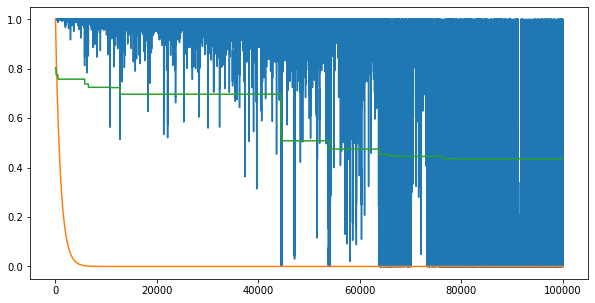

In [109]:
# plot iteration
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 5))
# plot accept prob
plt.plot(accps, label="accept prob")
# plot temp
plt.plot(np.exp(-1 / np.array(Ts)), label="temp")
# plot bls
plt.plot(bls, label="best loss")


In [110]:
est_df = pd.DataFrame(
    {
        "idx": idxs,
        "prior": best_estimate,
    }
)
est_df["rank"] = est_df["prior"].rank(ascending=False)
est_df.sort_values(by="rank", inplace=True)
est_df


,idx,prior,rank
4,e10,1.000000,1.0
6,e12,0.168020,2.0
8,e14,0.008518,3.0
0,e6,0.000000,8.0
1,e7,0.000000,8.0
2,e8,0.000000,8.0
3,e9,0.000000,8.0
5,e11,0.000000,8.0
7,e13,0.000000,8.0
9,e15,0.000000,8.0


In [70]:
r1_idx = idxs.index(est_df.iloc[0].idx)

best_estimate, best_loss = None, None
for _ in range(100000):
    estimate = np.random.rand(12)
    estimate[r1_idx] = 0
    l = loss(estimate)
    if best_loss is None or l < best_loss:
        best_estimate, best_loss = estimate, l

In [71]:
est_df = pd.DataFrame(
    {
        "idx": idxs,
        "prior": best_estimate,
    }
)
est_df["rank"] = est_df["prior"].rank(ascending=False)
est_df.sort_values(by="rank", inplace=True)
est_df

,idx,prior,rank
10,e16,0.953937,1.0
5,e11,0.434853,2.0
1,e7,0.312240,3.0
3,e9,0.253155,4.0
7,e13,0.167799,5.0
2,e8,0.157152,6.0
8,e14,0.121046,7.0
9,e15,0.118441,8.0
6,e12,0.096878,9.0
11,e17,0.078345,10.0


In [72]:
r2_idx = idxs.index(est_df.iloc[0].idx)

best_estimate, best_loss = None, None
for _ in range(100000):
    estimate = np.random.rand(12)
    estimate[r1_idx] = 0
    estimate[r2_idx] = 0
    l = loss(estimate)
    if best_loss is None or l < best_loss:
        best_estimate, best_loss = estimate, l

est_df = pd.DataFrame(
    {
        "idx": idxs,
        "prior": best_estimate,
    }
)
est_df["rank"] = est_df["prior"].rank(ascending=False)
est_df.sort_values(by="rank", inplace=True)
est_df

,idx,prior,rank
1,e7,0.883066,1.0
6,e12,0.399484,2.0
2,e8,0.302223,3.0
5,e11,0.247080,4.0
7,e13,0.162843,5.0
9,e15,0.153956,6.0
3,e9,0.115725,7.0
11,e17,0.113155,8.0
0,e6,0.067493,9.0
8,e14,0.058714,10.0
